In [1]:
%matplotlib inline
import Utilities.raster_utils as rast
import Utilities.stats_utils as stats
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats.kde import gaussian_kde
from sklearn import cluster as Kclust, metrics
from sklearn import preprocessing

In [2]:
base_str = 'Imagery_Data/L8'

def multi_img_to_array(multi_image_list):
    ravel_list = map(np.ravel, multi_image_list)
    return np.array(ravel_list)

def normalize_(imgs):
    return preprocessing.normalize(imgs, norm='l2', axis=1)

#################
# Load the data #
#################

#Ground truth data
NLCD = rast.read_raster('Imagery_Data/NLCD_2011.tif')

#Get TOA reflectance for the red and NIR bands
GREEN = rast.transform_TOA(base_str, 3)
RED = rast.transform_TOA(base_str, 4)
NIR = rast.transform_TOA(base_str, 5)
SWIR = rast.transform_TOA(base_str, 6)
TIR = rast.transform_sat_brightness_temp(base_str, 11)

#Wide Dynamic Range Veg Index
WDRVI = rast.calc_normalized_diff(NIR, RED, alpha=0.9)
#Normalized Diff Water Index
NDWI = rast.calc_normalized_diff(GREEN, NIR, alpha=1.0)

NISI_ = rast.NISI(GREEN, SWIR, NIR, TIR)


Utilities/raster_utils.py:138: RuntimeWarning: invalid value encountered in greater
  x[np.where(x>0.6375)] = 0.6375
Utilities/raster_utils.py:214: RuntimeWarning: invalid value encountered in divide
  return (alpha*b1 - b2)/(alpha*b1 + b2)


In [38]:
#inputs = map(stats.scale_image,[NISI_, WDRVI, NDWI])
#cents,clust = stats.k_means(inputs, k=5)

#plt.figure(figsize = (20,20))
#plt.set_cmap('RdYlGn')
#plt.imshow(clust)


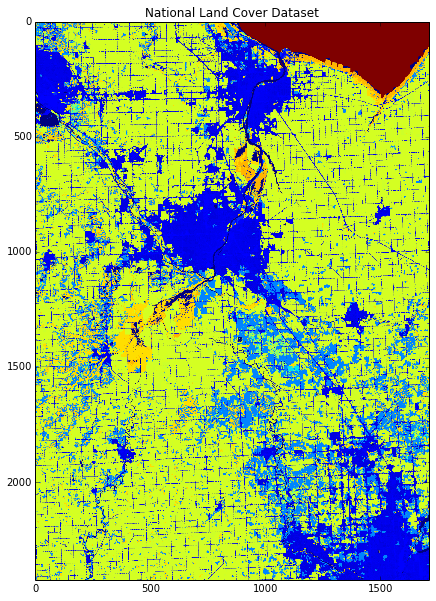

In [35]:
plt.figure(figsize = (10,10))

plt.imshow(NLCD);
plt.title('National Land Cover Dataset')

In [3]:
#######################################################
#From the NLCD FAQ: file:///Users/john/Downloads/land_use_land_cover_NLCD_mbr_3038831_01/land_use_land_cover%5Cnlcd_2011_faq.html
#
#The simplified land cover types are:
# - 1: Water
# - 2: Developed land
# - 3: Barren
# - 4: Forest
# - 5: Scrub
# - 7: Grassland
# - 8: Cultivated Land
# - 9: Wetland
#######################################################

def group_NLCD(array):
    return (array / 10).astype(int)


In [8]:
simple_NLCD = group_NLCD(NLCD)

#Build the test and training datasets for our model
test = np.dstack((simple_NLCD,WDRVI, NDWI, NISI_))[:, :850]
train = np.dstack((simple_NLCD,WDRVI, NDWI, NISI_))[:,850:]

#no documentation for NLCD value `128` removing from the training data
train_sample = np.array(stats.two_step_sample(train, 10000, (50,50)))
train_sample = np.delete(train_sample, np.where(train_sample[:,0]==12)[0], axis=0)
test_sample = np.array(stats.two_step_sample(test, 10000, (50,50)))

#Plotting functions
def plt_data(dataset):
    plt.figure(figsize = (10,2))
    plt.subplot(131)
    stats.plt_density(dataset[:,1], title='WDRVI')
    plt.subplot(132)
    stats.plt_density(dataset[:,2], title='NDWI')
    plt.subplot(133)
    stats.plt_density(dataset[:,3], title='NISI')
    plt.tight_layout()

### Data Overview

Let's take a look at the distributions of the data for each of the variables we are using in our model:
* NDVI: Normalized Difference Vegetative Index
* NDWI: Normalized Difference Water Index
* NISI: Normalized Impervious Surface Index

Each of these is meant to capture a different feature of the landscape (Vegetation, Water, Impervious surfaces), so we should expect to see some seperation between the primary land cover types.

First, the full data set.

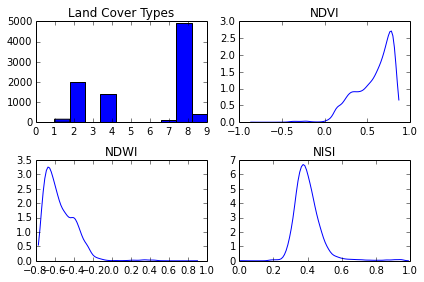

In [9]:
ax1 = plt.subplot(221)
ax1.hist(train_sample[:,0]);
ax1.set_title('Land Cover Types')
plt.subplot(222)
stats.plt_density(train_sample[:,1], title='NDVI')
plt.subplot(223)
stats.plt_density(train_sample[:,2], title='NDWI')
plt.subplot(224)
stats.plt_density(train_sample[:,3], title='NISI')
plt.tight_layout()


Now lets take a look at each of the three main land cover types:
* 2: Developed land
* 4: Forest
* 8: Cultivated land

The first one, developed land, does not look too different than the overall dataset.

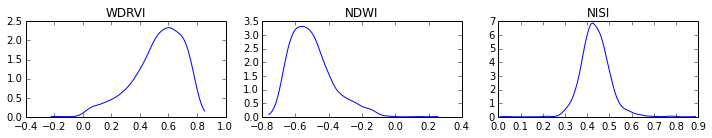

In [11]:
def subset(array, grp):
    return array[np.where(array[:,0]==grp)]

sub_developed = subset(train_sample, 2)
plt_data(sub_developed)

The forested landscape, shown below, does present a distinct profile

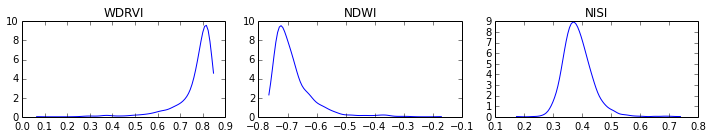

In [12]:
sub_4 = subset(train_sample, 4)
plt_data(sub_4)

Finally, the cultivated land. Here we see a bimodal distribution in the NDVI and NDWI, most likily because some of the land is covered by green vegetation in the image while other fields are bare or growing winter wheat that has already begun to dry down.

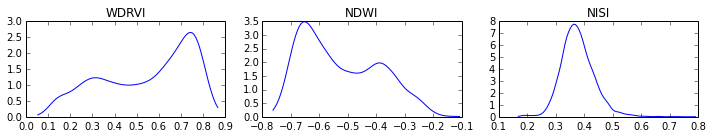

In [13]:
sub_8 = subset(train_sample, 8)
plt_data(sub_8)

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

#Build a random forest model

rf_model = RandomForestClassifier(n_estimators=100, criterion="entropy",oob_score=True,max_features="sqrt",random_state=53478,min_samples_split=10)
rf_model.fit(train_sample[:,1:],train_sample[:,0])
y_pred = rf_model.predict(test_sample[:,1:])
confusion_matrix(y_pred, test_sample[:,0])

array([[  78,    7,    1,    2,    1,    0,    7,   12],
       [  13,  626,    0,   70,    3,    5,  686,   73],
       [   0,    0,    0,    0,    0,    0,    0,    0],
       [  13,   41,    0,  490,    5,    6,   93,  427],
       [   0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0],
       [  10,  749,   12,  320,   10,   49, 5005,  254],
       [  28,   16,    2,   10,    0,    3,   18,   46]])

In [36]:
pred_image = np.copy(test[:,:,0])
_x,_y = np.where(~np.isnan(test[:,:,1]))
pred_image[_x,_y] = rf_model.predict(test[_x,_y,1:])

Let's take a look at the predicted land cover image. There is a clear relationship between the two images (predicted and actual), but we are overestimating cultivated land at the exenpense of developed land.

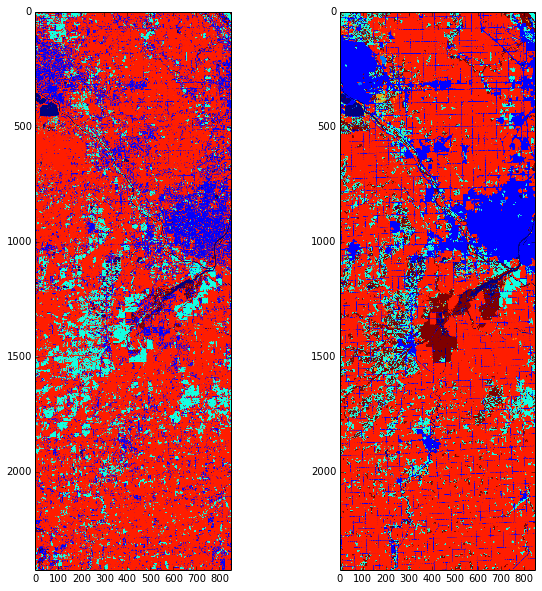

In [30]:
plt.figure(figsize = (10,10))
plt.subplot(121)
plt.imshow(pred_image)
plt.subplot(122)
plt.imshow(test[:,:,0])